In [99]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [100]:
DATA_TRAIN_PATH = "../data/train.csv"
labels, data, ids = load_csv_data(DATA_TRAIN_PATH)

In [101]:
feature_names = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]
categorical_variable = feature_names.index("PRI_jet_num")

# Exploratory data analysis

How many events are there compared to non-events?

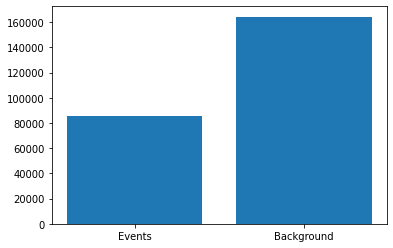

In [4]:
events = np.count_nonzero(labels == 1)
nonevents = len(labels) - events
plt.bar(["Events", "Background"], [events, nonevents])
plt.show()

There's roughly twice as many background noise as there are events in the training set. We have to be careful of this fact when using cross-validation.

How is it distributed with regards to PRI_jet_num?

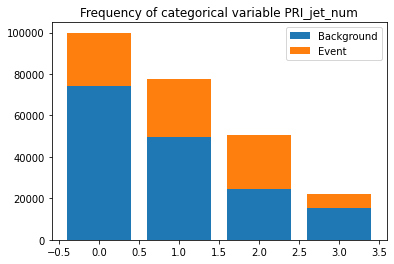

In [5]:
events = data[np.where(labels == 1)]
nonevents = data[np.where(labels != 1)]

unique, counts = np.unique(nonevents[:,categorical_variable], return_counts=True)
plt.bar(unique, counts)
_, counts2 = np.unique(events[:,categorical_variable], return_counts=True)
plt.bar(unique, counts2, bottom=counts)
plt.legend(["Background", "Event"])
plt.title("Frequency of categorical variable PRI_jet_num")
plt.show()

## Which features should be merged together?

In [6]:
def generate_correlation_set(tX, t):
    corr_set = set()
    df = pd.DataFrame(tX)
    corr = df.corr()
    for i, row in enumerate(corr):
        for j, col in enumerate(corr):
            if i != j and corr.loc[i,j] > t:
                corr_set.add((i,j))
                
    return _pairs_to_groups(corr_set)

def _pairs_to_groups(pairs):
    groups = set()
    edges = _create_dict_from_tuples(pairs)
    vertices = edges.keys()
    done = set()

    for vertex in vertices:
        if vertex not in done:
            groups.add(frozenset(_depth_first_search(vertex, edges, done)))

    return groups

def _depth_first_search(vertex, edges, done):
    group = {vertex}
    done.add(vertex)

    for v_adj in edges[vertex]:
        if v_adj not in done:
            group.update(_depth_first_search(v_adj, edges, done))

    return group

def _create_dict_from_tuples(tuples):
    dict_ = dict()

    for x, y in tuples:
        if x not in dict_:
            dict_[x] = set()
        dict_[x].add(y)

    return dict_

# Data processing

There's a few different approaches we could take for feature processing:
1. Divide the dataset into four, one for each categorical variable.
2. Split the categorical variable into multiple boolean columns, one for each type it could be.

Regardless, the data should be properly normalized beforehand (made exception for the categorical variable), as not normalizing it leads to overflows when running any sort of regression

In [7]:
mean, std = np.mean(data, axis=0), np.std(data, axis=0)

Logistic regression expects labels to be of the form {0, 1}.  
Since the labels given to us are instead of the form {-1, 1}, we also need to normalize them to use logistic regression.
Other forms of regression work well no matter the form of the labels, so we stick with {0, 1}

In [5]:
def normalize_labels(labels):
    return np.round((labels + 1) / 2)

## Compare methods & Optimize hyperparameters
Let's see which of the regression methods performs best using k-fold cross validation

In [102]:
from validation import *
from implementations import *

y = normalize_labels(labels)
tx = data

In [103]:
k = 6
indices = build_k_indices(len(y), k)
# cross_validation(y, tx, indices,)

In [104]:
def cartesian_product(x, y):
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

In [110]:
max_iters = 50
initial_w = np.mean(tx,axis=0)
gammas = [1*(10**-i) for i in range(1,6)]
lambdas = np.logspace(-8, -2, 7)
hyperparams = cartesian_product(gammas, lambdas)

def gradient_descent(train_function):
    return lambda y, tx, param: train_function(y, tx, initial_w, max_iters, param)

def gradient_descent_multi(train_function):
    return lambda y, tx, param: train_function(y, tx, initial_w, max_iters, *param)

In [ ]:
k = 6
indices = build_k_indices(len(y), k)
method_results = {
    'Least squares GD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(least_squares_GD)),
    'Least squares SGD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(least_squares_SGD)),
    'Explicit least squares' : cross_validation(y, tx, indices, least_squares),
    'Ridge regression' : nested_cross_validation(y, tx, indices, lambdas, ridge_regression),
    'Logistic regression GD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(logistic_reg_GD)),
    'Regularized log. regression GD' : nested_cross_validation(y, tx, indices, hyperparams, gradient_descent_multi(penalized_logistic_reg_GD))
}

Best hyperparam for iteration 0: 0.1, acc: 0.36902458779222863
Best hyperparam for iteration 1: 0.1, acc: 0.36903898917462097


In [ ]:
results = np.array(list(method_results.values()))
plt.barh(list(method_results.keys()), results[:, 0], xerr=results[:, 1])
plt.xlim(0, 1)
plt.xlabel("Correct prediction ratio")
plt.title("Results of full regression (all variables)")
plt.savefig("../figs/regresults.pdf")
plt.show()

In [94]:
def feature_augmentation(tx, degree):
    powers = [np.power(tx, deg) for deg in range(1,degree+1)]
    return np.concatenate(powers, axis=1)

In [98]:
from validation import *
from implementations import *

labels, data, ids = load_csv_data(DATA_TRAIN_PATH)
mean, std = np.mean(data, axis=0), np.std(data, axis=0)
y = normalize_labels(labels)
tx = data
lambda_ = 1e-8

k = 6
indices = build_k_indices(len(y), k)

fa = feature_augmentation(tx_, i)
initial_w = np.zeros(fa.shape[1])
method = lambda y, tx: ridge_regression(y, tx, lambda_)
cross_validation(y, tx, indices, method)

# print("Degree 1:", cross_validation(y, tx, indices, method))
# print("Degree 2:", cross_validation(y, feature_augmentation(tx, 2), indices, method))

Degree 1: [0.6727240052381506, 0.0016246735501499307]
Degree 2: [0.7629720118097549, 0.0027612590058551894]
Degree 3: [0.7707960060507103, 0.003015763362032697]
Degree 4: [0.7814400073000828, 0.0029868852972744367]
Degree 5: [0.791044005061294, 0.002660063374330084]
Degree 6: [0.7953160031418256, 0.0024384254790093857]
Degree 7: [0.796652002437991, 0.0028230572645703395]
Degree 8: [0.7999120023744077, 0.003055589605201434]
Degree 9: [0.8034879863427372, 0.003503348721795174]
Degree 10: [0.808635997959489, 0.003362554635718197]
Degree 11: [0.8124000004879912, 0.0031980982723088473]
Degree 12: [0.8023560265989143, 0.014381143736618567]
Degree 13: [0.7528515831010298, 0.04847834471615634]
Degree 14: [0.7310441576948352, 0.0914624744248736]


least squares
Degree 1: [0.6727359966940839, 0.0033396339599676287]
Degree 2: [0.7689039835542882, 0.002250319518331648]
Degree 3: [0.7544556298856094, 0.050378527866572764]
Degree 4: [0.7870400037807714, 0.002041371430358621]
Degree 5: [0.7960840017979133, 0.0018645413642967516]
Degree 6: [0.7982560030462013, 0.0028332752689231096]
Degree 7: [0.7701439693143328, 0.02154082470313782]
Degree 8: [0.7206324758080473, 0.09673616499969533]
Degree 9: [0.7005284220770442, 0.1114349333454626]
Degree 10: [0.7137839856912498, 0.07819875150936996]
Degree 11: [0.7551400040966908, 0.029170768811499517]
Degree 12: [0.6463037573287855, 0.07110401750097665]
Degree 13: [0.6766041511278144, 0.08559541679397659]
Degree 14: [0.6834003486662646, 0.04393376533452371]

ridge regression
Degree 1: [0.6727800066141687, 0.001381963958043767]
Degree 2: [0.7629040151377727, 0.002552190914967387]
Degree 3: [0.7706560136987536, 0.002836028364255326]
Degree 4: [0.7815000072040896, 0.002719140839882505]
Degree 5: [0.7909680092213177, 0.0027718568138764563]
Degree 6: [0.7950360071098216, 0.001963070829461227]
Degree 7: [0.7961840097339894, 0.0018379415428500907]
Degree 8: [0.7921640702139587, 0.015547436016873204]
Degree 9: [0.8027800117828501, 0.0015084107676194695]
Degree 10: [0.807508016007489, 0.0014915298774878767]
Degree 11: [0.8096400193037884, 0.002092523197171315]
Degree 12: [0.8054560625675989, 0.009661994950285885]
Degree 13: [0.7052439922822096, 0.07455239357118361]
Degree 14: [0.7780361763249992, 0.028592400772404356]

In [23]:
ls = np.array([
    [0.6727359966940839, 0.0033396339599676287],
    [0.7689039835542882, 0.002250319518331648],
    [0.7544556298856094, 0.050378527866572764],
    [0.7870400037807714, 0.002041371430358621],
    [0.7960840017979133, 0.0018645413642967516],
    [0.7982560030462013, 0.0028332752689231096],
    [0.7701439693143328, 0.02154082470313782],
    [0.7206324758080473, 0.09673616499969533],
    [0.7005284220770442, 0.1114349333454626],
    [0.7137839856912498, 0.07819875150936996],
    [0.7551400040966908, 0.029170768811499517],
    [0.6463037573287855, 0.07110401750097665],
    [0.6766041511278144, 0.08559541679397659],
    [0.6834003486662646, 0.04393376533452371]
])
rr = np.array([
    [0.6727800066141687, 0.001381963958043767],
    [0.7629040151377727, 0.002552190914967387],
    [0.7706560136987536, 0.002836028364255326],
    [0.7815000072040896, 0.002719140839882505],
    [0.7909680092213177, 0.0027718568138764563],
    [0.7950360071098216, 0.001963070829461227],
    [0.7961840097339894, 0.0018379415428500907],
    [0.7921640702139587, 0.015547436016873204],
    [0.8027800117828501, 0.0015084107676194695],
    [0.807508016007489, 0.0014915298774878767],
    [0.8096400193037884, 0.002092523197171315],
    [0.8054560625675989, 0.009661994950285885],
    [0.7052439922822096, 0.07455239357118361],
    [0.7780361763249992, 0.028592400772404356]
])

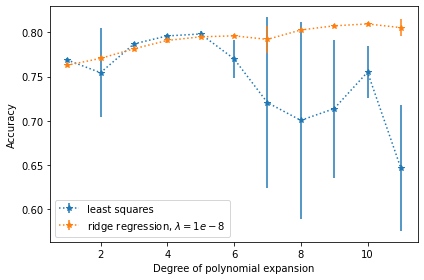

In [67]:
x = range(1,12)

ls_y = ls[1:12,0]
ls_e = ls[1:12,1]

rr_y = rr[1:12,0]
rr_e = rr[1:12,1]

plt.errorbar(x,ls_y,ls_e, linestyle='dotted', marker='*')
plt.errorbar(x,rr_y,rr_e, linestyle='dotted', marker='*')

plt.xlabel("Degree of polynomial expansion")
plt.ylabel("Accuracy")

plt.legend(["least squares", "ridge regression, $\lambda=1e-8$"])

plt.tight_layout()
plt.savefig("augmentation.pdf")
plt.show()

# Create a (simple) submission

In [33]:
DATA_TEST_PATH = "../data/test.csv"
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [34]:
OUTPUT_PATH  = "../data/predictions.csv"

weights, _ = ridge_regression(labels, tx, lambda_)
labels_test = predict_labels(weights, tx_test)
create_csv_submission(ids_test, labels_test, OUTPUT_PATH)

## Separating data by group

In [42]:
useless_features = {
    0: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_leading_pt", "PRI_jet_leading_eta", "PRI_jet_leading_phi",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi","PRI_jet_all_pt"
       ],
    1: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi"
       ],
    2: [],
    3: []
}


def group_by_jet_num(y, tx, jet_num):
    indices = np.where(tx[:, categorical_variable] == jet_num)
    useless = useless_features[jet_num] + ["PRI_jet_num"]
    useless_indices = [feature_names.index(feat) for feat in useless]
    tx_ = np.delete(tx, useless_indices, axis=1)
    return [y[indices], tx_[indices]]


def group_data(y, tx):
    data_grouped = [
        group_by_jet_num(y, tx, jet_num)
        for jet_num in range(4)
    ]
    # Create one single group for jet_nums 2 and 3
    data_grouped[2][0] = np.concatenate([data_grouped[2][0], data_grouped[3][0]])
    data_grouped[2][1] = np.concatenate([data_grouped[2][1], data_grouped[3][1]])
    data_grouped.pop(3)
    return data_grouped

In [115]:
from validation import *
from implementations import *

In [116]:
labels, data, _ = load_csv_data(DATA_TRAIN_PATH)
y = normalize_labels(labels)

avg_acc = np.zeros(2)
lambda_ = 1e-8
method = lambda y, tx: ridge_regression(y, tx, lambda_)

for y, tx in group_data(y, data):
    indices = build_k_indices(len(y), 5)
    avg_acc += cross_validation(y, tx, indices, method)
avg_acc / len(data_grouped)

array([0.82316453, 0.00370001])

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)

def calculate_weights(y, tx):     
    tx = feature_expansion(tx)
    weights, _ = least_squares(y, tx)
    return weights

w_by_group = [calculate_weights(y, tx) for y, tx in group_data(y, tx)]

In [ ]:
OUTPUT_PATH = 'predictions.csv'

def predict_labels_grouped(w_by_group, ids, data):
    """Generates class predictions given weights, and a test data matrix"""
    data_grouped = group_data(ids, data) # List[ (Id, tX)]
    y_pred = np.array([])
    ids_pred = np.array([])
    for group, w in zip(data_grouped, w_by_group):
        ids, tx = group
        tx = feature_expansion(tx)
        y_pred = np.concatenate([y_pred, tx @ w])
        ids_pred = np.concatenate([ids_pred, ids])
    y_pred[y_pred > 0] = 1
    y_pred[y_pred <= 0] = -1
    return y_pred, ids_pred

y_pred, ids_pred = predict_labels_grouped(w_by_group, ids_test, tX_test)
pred_arr = np.column_stack((ids_pred, y_pred))
sorted_pred = pred_arr[pred_arr[:,0].argsort()]

create_csv_submission(sorted_pred[:, 0], sorted_pred[:, 1], OUTPUT_PATH)